# NBA Team Logo Classification 24/25

In [ ]:
# Load Datasets from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Library Used

In [4]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split

#Viz
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

#Tensorflow
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

#System libraries
import PIL
from PIL import UnidentifiedImageError
from pathlib import Path
import os

#Metrics
from sklearn.metrics import confusion_matrix, classification_report

sns.set_style('darkgrid')

In [5]:
#Seed everything
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

## Load Dataset

In [8]:
#Accesing drive location
dataset = '/content/drive/MyDrive/NBA Team Logo Classification/NBA Teams Logo'
sorted(os.listdir(dataset))

['Atlanta Hawks',
 'Boston Celtics',
 'Brooklyn Nets',
 'Charlotte Hornets',
 'Chicago Bulls',
 'Cleveland Cavaliers',
 'Dallas Mavericks',
 'Denver Nuggets',
 'Detroit Pistons',
 'Golden State Warriors',
 'Houston Rockets',
 'Indiana Pacers',
 'Los Angeles Clippers',
 'Los Angeles Lakers',
 'Memphis Grizzlies',
 'Miami Heat',
 'Milwaukee Bucks',
 'Minnesota Timberwolves',
 'New Orleans Pelicans',
 'New York Knicks',
 'Oklahoma City Thunder',
 'Orlando Magic',
 'Philadelphia 76ers',
 'Phoenix Suns',
 'Portland Trail Blazers',
 'Sacramento Kings',
 'San Antonio Spurs',
 'Toronto Raptors',
 'Utah Jazz',
 'Washington Wizards']

In [9]:
# Set image batch and resolution
BATCH_SIZE = 64
TARGET_SIZE = (244,244)

In [10]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

In [ ]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/NBA Team Logo Classific...,Portland Trail Blazers
1,/content/drive/MyDrive/NBA Team Logo Classific...,Portland Trail Blazers
2,/content/drive/MyDrive/NBA Team Logo Classific...,Portland Trail Blazers
3,/content/drive/MyDrive/NBA Team Logo Classific...,Portland Trail Blazers
4,/content/drive/MyDrive/NBA Team Logo Classific...,Portland Trail Blazers
...,...,...
595,/content/drive/MyDrive/NBA Team Logo Classific...,Atlanta Hawks
596,/content/drive/MyDrive/NBA Team Logo Classific...,Atlanta Hawks
597,/content/drive/MyDrive/NBA Team Logo Classific...,Atlanta Hawks
598,/content/drive/MyDrive/NBA Team Logo Classific...,Atlanta Hawks


In [ ]:
# Check corrupted images
path = Path(dataset).rglob("*.jpg")
for img_p in path:
  try:
    img = PIL.Image.open(img_p)
  except PIL.UnidentifiedImageError:
    print(img_p)

KeyboardInterrupt: 

In [11]:
label_counts = image_df['Label'].value_counts()
label_counts

,count
Label,
Portland Trail Blazers,20
Toronto Raptors,20
Philadelphia 76ers,20
Utah Jazz,20
Phoenix Suns,20
Washington Wizards,20
San Antonio Spurs,20
Oklahoma City Thunder,20
Sacramento Kings,20


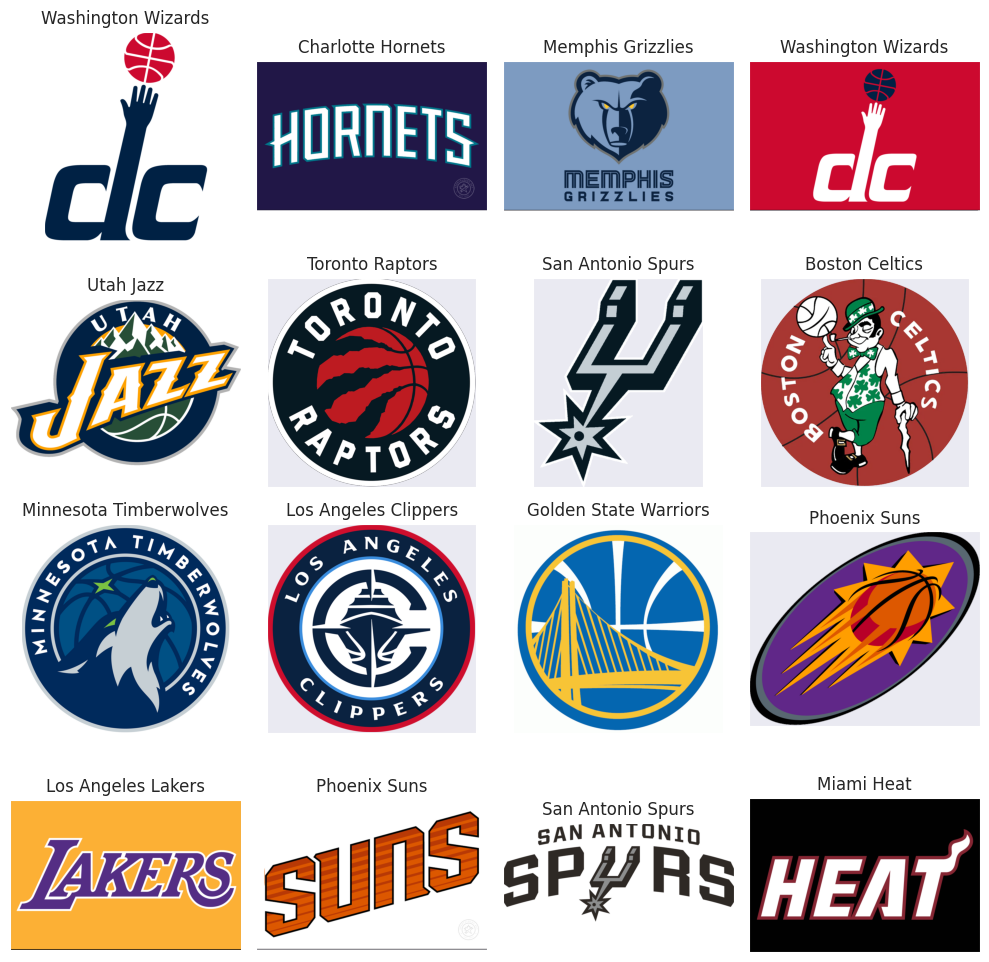

In [ ]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

## Data Preprocessing

In [20]:
train_df, test_df = train_test_split(image_df, test_size=0.20, shuffle=True, random_state=seed)

In [21]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

In [22]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(244, 244),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42
)

val_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(244, 244),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False,
    seed=42,
)

Found 480 validated image filenames belonging to 30 classes.
Found 120 validated image filenames belonging to 30 classes.


In [23]:
train_images

In [24]:
augment = tf.keras.Sequential([
  layers.Resizing(244,244),
  layers.Rescaling(1./255),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.1)
])

## Model Train

In [25]:
pretrained_model = tf.keras.applications.vgg19.VGG19(
    input_shape=(244,244,3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=1e-10
)

In [26]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)

outputs = Dense(30, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 244, 244, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 244, 244, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 122, 122, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 122, 122, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 122, 122, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 61, 61, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 61, 61, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 61, 61, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 61, 61, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 61, 61, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,132,830 (76.80 MB)

 Trainable params: 107,422 (419.62 KB)

 Non-trainable params: 20,025,408 (76.39 MB)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        reduce_lr
    ]
)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


KeyboardInterrupt: 

## Model Evaluation

In [27]:
# Model Accuracy
results = model.evaluate(val_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

ValueError: You must call `compile()` before using the model.

In [28]:
# classification report
y_pred = model.predict(val_images)
y_pred = np.argmax(y_pred, axis=1)
y_true = val_images.classes
class_labels = list(val_images.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 743ms/step
                        precision    recall  f1-score   support

         Atlanta Hawks       1.00      1.00      1.00         8
        Boston Celtics       1.00      1.00      1.00         3
         Brooklyn Nets       1.00      1.00      1.00         2
     Charlotte Hornets       1.00      1.00      1.00         7
         Chicago Bulls       1.00      0.80      0.89         5
   Cleveland Cavaliers       1.00      1.00      1.00         2
      Dallas Mavericks       0.80      1.00      0.89         4
        Denver Nuggets       1.00      1.00      1.00         5
       Detroit Pistons       1.00      1.00      1.00         3
 Golden State Warriors       1.00      1.00      1.00         2
       Houston Rockets       1.00      1.00      1.00         1
        Indiana Pacers       1.00      1.00      1.00         4
  Los Angeles Clippers       1.00      1.00      1.00         2
    Los Angeles Lakers       1.00      1.00      1.00         7


In [ ]:
#save model
model.save('model.h5')

In [29]:
model = tf.keras.models.load_model('model.h5')

In [30]:
# image preprocessing
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(244, 244))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

In [ ]:
# Model Testing on Imported Images
from google.colab import files
uploaded = files.upload()

for name, data in uploaded.items():
  with open(name, 'wb') as f:
    f.write(data)
    f.close()

image_path = name
prep = tf.keras.preprocessing.image.load_img(image_path, target_size=(244, 244))
plt.imshow(prep)
plt.axis('off')
plt.show()

TypeError: 'NoneType' object is not subscriptable

In [15]:
#model predict
class_labels = list(val_images.class_indices.keys())
class_labels[np.argmax(model.predict(preprocess_image(image_path)))]

NameError: name 'val_images' is not defined

In [ ]:
#percentage
print("akurasi sebesar: ", np.max(model.predict(preprocess_image(image_path)))*100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
akurasi sebesar:  98.0181634426117


In [ ]:
#get top 3 accuracy
top_k = 3
top_k_indices = np.argsort(model.predict(preprocess_image(image_path)))[0, -top_k:][::-1]
top_k_labels = [class_labels[i] for i in top_k_indices]
top_k_probabilities = [model.predict(preprocess_image(image_path))[0][i] for i in top_k_indices]
top_k_probabilities = [round(p * 100, 2) for p in top_k_probabilities]
print("Top", top_k, "labels:", top_k_labels)
print("Top", top_k, "probabilities:", top_k_probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Top 3 labels: ['Denver Nuggets', 'Washington Wizards', 'Orlando Magic']
Top 3 probabilities: [61.7, 6.87, 5.82]
